In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import astropy.units as u

plt.rcParams['font.size'] = 20

# Problem 1

For this problem, my function rk4_step uses the conventional RK4 method to integrate the following differential equation

$$\frac{dy}{dx} = \frac{y}{1+x^2}$$

from $x = -20$ to $x = 20$ using 200 steps. 

Then, my function rk4_stepd uses step doubling to improve the accuracy of our estimate from 4th to 5th order. In step doubling RK4, one evaluates the new value of $y$ twice. The first time after taking a step of size $h$, the second time after taking 2 steps of size $\frac{h}{2}$. Using both of these new estimates for $y(x + h)$, we can reach that higher 5th order accuracy with 11 function evaluations.

In order to fairly compare the accuracy of using step doubling vs using the conventional RK4 method, I ran the step doubling algorithm for $N_{steps} = 200 \times \frac{4}{11} \approx 72$. By reducing the number of steps taken by the improved method, we had approximately the same number of function calls than with the conventional method.

In [2]:
def f(x, y):
    return y / (1 + x**2)

In [3]:
def rk4_step(fun,x,y,h):
    '''conventional RK4 integrator'''
    k1=fun(x,y)*h
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    return y+dy

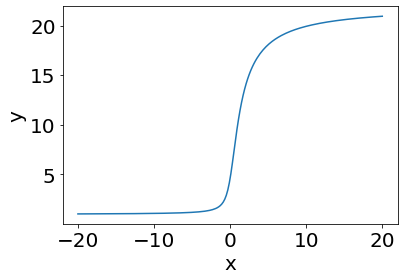

In [4]:
xs = np.linspace(-20, 20, 200)
h = xs[1] - xs[0]
y0 = 1
ys = [y0]
for i in range(len(xs)-1):
    ys.append(rk4_step(f,xs[i],ys[i],h))
    
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
def rk4_stepd(fun,x,y,h):
    '''Step doubling RK4 integrator'''
    # 1 big step
    ybig = rk4_step(fun,x,y,h)
    
    # 2 smaller steps
    _ = rk4_step(fun,x,y,h/2)
    ysmall = rk4_step(fun,x+h/2,_,h/2)
    
    delta = ysmall - ybig 
    ybest = ysmall + delta/15
    
    return ybest

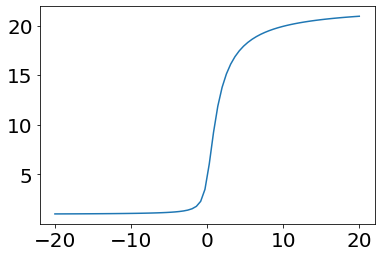

In [6]:
xs_step = np.linspace(-20, 20, int(200 * (4/11)))
h = xs_step[1] - xs_step[0]
ys_step = [y0]
for i in range(len(xs_step)-1):
    ys_step.append(rk4_stepd(f,xs_step[i],ys_step[i],h))

plt.plot(xs_step, ys_step)
plt.show()

In [7]:
# setting up the real solution to the differential equation for comparison
c = 1 / np.exp(np.arctan(-20))
real = c*np.exp(np.arctan(xs))
real_step = c*np.exp(np.arctan(xs_step))

In [8]:
first = np.std(np.abs(ys - real))
second = np.std(np.abs(ys_step - real_step))
print('accuracy with first method', first)
print('accuracy with second method', second)

accuracy with first method 0.00012015197423194706
accuracy with second method 2.3835730825213482e-05


In [9]:
first/second

5.040834498132949

The results show that even with a decrease in the number of steps to match the number of function calls, the step doubling RK4 method outperformed the conventional one by a factor of $\approx 5$ in accuracy.

# Problem 2

## a)

To set up this problem, I first stored all of the half-lifes of the products in the decay chain converted to years to ensure the units matched up. Because we have a very large difference between some of the half-lifes (U-238 with $4.468 \times 10^9$ years and other elements with fractions of a second), we know we have a stiff equation representing these transitions. In order to better deal with this, we use the Radau method for the scipy integrator.

In [10]:
elements = ['U-238',
           'Th-234',
           'Pa-234',
           'U-234',
           'Th-230',
           'Ra-226',
           'Rn-2223',
           'Po-218',
           'Pb-214',
           'Bu-214',
           'Po-214',
           'Pb-210',
           'Bi-210',
           'Po-210',
           'Pb-206']

In [11]:
life_ = [4.468e9 * u.yr,
           24.10 * u.day,
           6.70 * u.hr,
           245500 * u.yr,
           75380 * u.yr,
           1600 * u.yr,
           3.8235 * u.d,
           3.10 * u.min,
           26.8 * u.min,
           19.9 * u.min,
           164.3e-6 * u.s,
           22.3 * u.yr,
           5.015 * u.yr,
           138376 * u.d]

life = []
for l in life_:
    life.append(l.to(u.yr).value)

In [12]:
def fun(x,y,lifetime=life):
    
    dydx=np.zeros(len(lifetime)+1)
    
    
    for i in range(len(lifetime)+1):    

        # parent nuclei
        if i == 0:
            dydx[i] = -y[i]/lifetime[i]
        elif i == len(lifetime):
            dydx[i] = y[i-1]/lifetime[i-1]
        else:
            dydx[i] = -y[i]/lifetime[i] + y[i-1]/lifetime[i-1]

    return dydx

In [13]:
y0=np.zeros(len(life_)+1)
y0[0] = 10
x = np.linspace(0, 10, 101)
x0=0
x1=5e12

ans_stiff=integrate.solve_ivp(fun, [x0, x1], y0, method='Radau')

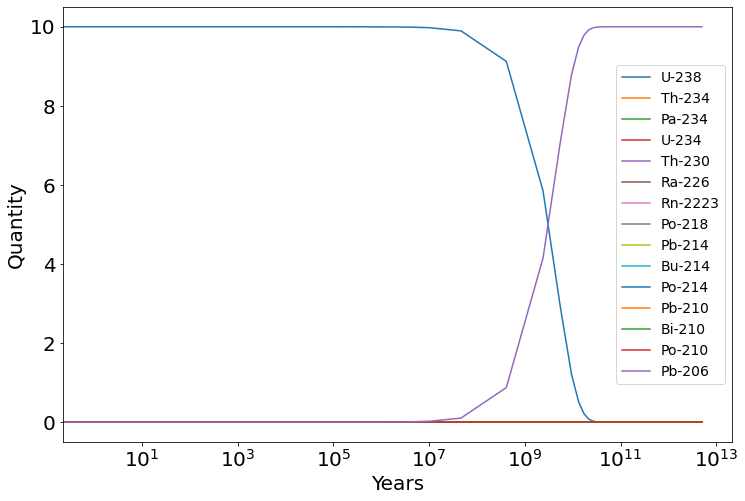

In [14]:
plt.figure(figsize=(12,8))
for i in range(len(ans_stiff.y)):
    plt.plot(ans_stiff.t, ans_stiff.y[i], label=elements[i])
    
plt.xlabel('Years')
plt.ylabel('Quantity')
plt.legend(fontsize=14)
plt.xscale('log')
plt.show()

Looking at the figure above, we see a very clear shift in the abundances of our initial element U-238 and the final stable element of the chain Pb-206. In this view, the elements of other steps of the chain seem to play a very small roll in this transition.

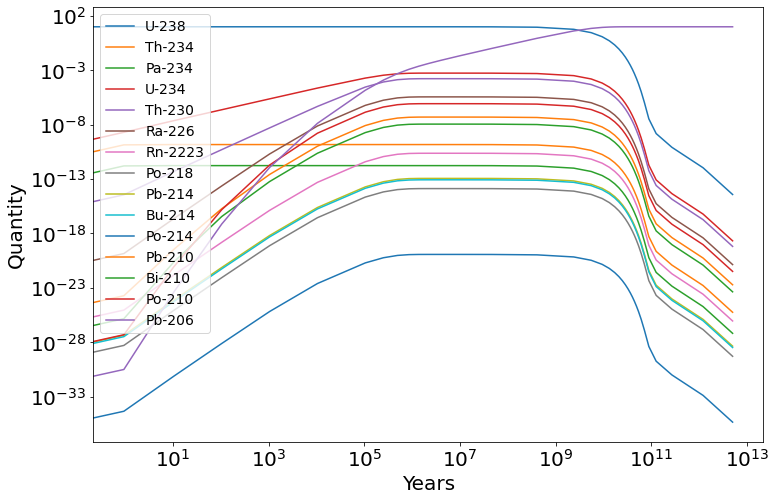

In [15]:
plt.figure(figsize=(12,8))
for i in range(len(ans_stiff.y)):
    plt.loglog(ans_stiff.t, ans_stiff.y[i], label=elements[i])
    
plt.xlabel('Years')
plt.ylabel('Quantity')
plt.legend(fontsize=14)
plt.show()

The figure above shows a log-log plot of the solutions for each element. Even though the transition in abundances of the first and last elements of the chain is not as clear, this view allows us to see the involvement of the other elements in the overall decay chain. We see that they rise as U-238 decayse but ultimately all decrease again as we get to the stable element of the chain.

## b)

If we look at the ratio of Pb-206 and U-238 over time, we see that at around $10^{12}$ years, the radio rapidly jumps from being very close to 0 to very large. This agrees with what we expect from U-238 decaying with half-life $\approx 10^{12}$ years. When we cross that point, and since the half-life of the other elements in the chain is negligible, we see a rapid increase in quantity of Pb-206. 

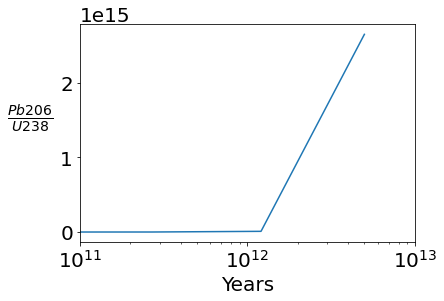

In [16]:
Pb206 = ans_stiff.y[-1]
U238 = ans_stiff.y[0]
plt.plot(ans_stiff.t, Pb206 / U238)
plt.xscale('log')
plt.xlim(1e11, 1e13)
plt.xlabel('Years')
plt.ylabel(r'$\frac{Pb206}{U238}$', rotation=0, labelpad=30)
plt.show()

If we look at the ratio of Th-230 to U-234 abundance over time, we see that the increase is more gradual. The interesting period happens between $10^3$ and $10^7$ years. Therefore, one could use the ratio of the abundances of Th-230 and U-234 to estimate the age of a rock that has been formed between those years. If the rock was formed with U-238 less than $1000$ years ago, we would expect the ratio to be close to 0. If the rock was older than about $10^6$ years, we would expect the ratio to be around the plateau value of $\approx 0.30$.

/var/folders/rw/43dtvf4s1cg4s4rbh9cx59240000gn/T/ipykernel_45753/3546660692.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ans_stiff.t, Th230 / U234)


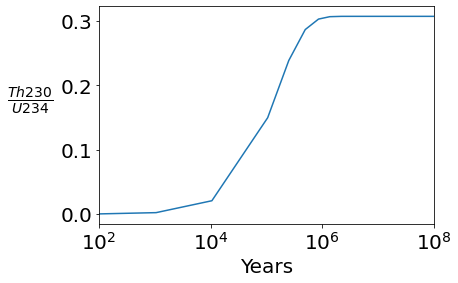

In [17]:
Th230 = ans_stiff.y[4]
U234 = ans_stiff.y[3]
plt.plot(ans_stiff.t, Th230 / U234)
plt.xscale('log')
plt.xlim(1e2, 1e8)
plt.xlabel('Years')
plt.ylabel(r'$\frac{Th230}{U234}$', rotation=0, labelpad=30)
plt.show()

# Problem 3

## a)

We have the following equation for a rotationally symmetric paraboloid

$$z - z_0 = a[(x-x_0)^2 + (y-y_0)^2]$$

In order to perform a linear least squares fit on the data, we need the model to depend on the patameters linearly. For that, we manipulate the equation as follows:

$$z - z_0 = a[x^2-2xx_0+x_0^2 + y^2-2yy_0+y_0^2]$$

Then, we set the following new parameters

$$b = -2ax_0, c = -2ay_0, d = ax_0^2 + ay_0^2 + z_0$$

$$\longrightarrow z = a(x^2 + y^2) + bx + cy + d$$

And now this model depends linearly on the new parameters $a, b, c, d$.

## b)

The first step was to load in the data and see what it looked like. We see the 3 views of the data in the figure below. After that, I performed a linear least-squares fit for the new established parameters $a, b, c, d$. The predicted $z$ values for the best fit parameters are also shown in the second figure down. 

To report the best-fit parameters, I transformed them back to the original parameters we had $(a, x_0, y_0, z_0)$ and the output was $\hat{m} \approx (0.1667, -0.0014, 0.0582, -1.5129)$ respectively.

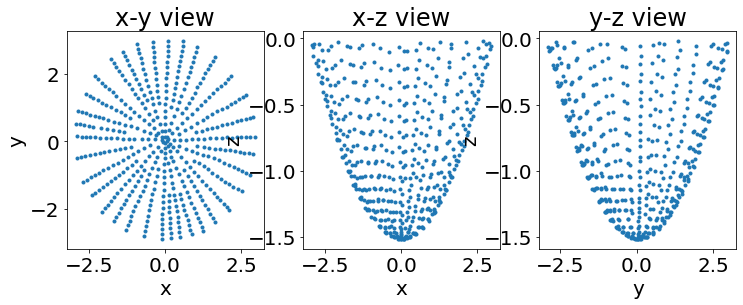

In [18]:
# loading the data and checking what it looks like
x, y, z = (np.loadtxt('./dish_zenith.txt').T)*u.mm.to(u.m)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].plot(x, y, '.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('x-y view')

ax[1].plot(x, z, '.')
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')
ax[1].set_title('x-z view')

ax[2].plot(y, z, '.')
ax[2].set_xlabel('y')
ax[2].set_ylabel('z')
ax[2].set_title('y-z view')
plt.show()

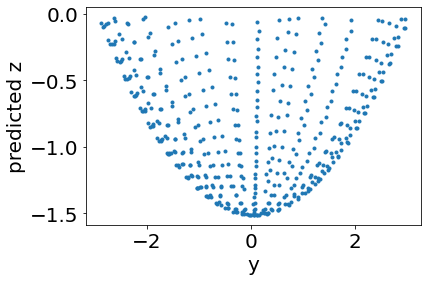

In [19]:
# creating model matrix A for the fit
A = np.zeros((len(x), 4))
A[:,0] = x**2 + y**2
A[:,1] = x
A[:,2] = y
A[:,3] = 1

# performing linear least-squares fit for the model parameters
lhs = A.T @ A
rhs = A.T @ z
# best-fit estimate for (linearized) parameters
m = np.linalg.inv(lhs) @ rhs

# checking that predicted data matches what we expect
pred = A @ m
plt.plot(y, pred, '.')
plt.xlabel('y')
plt.ylabel('predicted z')
plt.show()

In [20]:
def convert_params(params):
    '''converts linearized parameters into a, x0, y0, z0'''
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    
    x0 = -b / (2*a)
    y0 = -c / (2*a)
    z0 = d - a*x0**2 - a*y0**2
    
    return a, x0, y0, z0

In [21]:
orig = convert_params(m)
print('best-fit parameters are')
print('a =', orig[0], 'x0 =', orig[1], 'y0 =', orig[2], 'z0 =', orig[3])

best-fit parameters are
a = 0.16670445477401347 x0 = -0.0013604886221976196 y0 = 0.058221476081579474 z0 = -1.512877210036787


## c)


To estimate the error in the data, I looked at the difference between the measured and predicted data. From that, I created a noise matrix containing the error for each data point along the diagonal. I used that to calculate the variance of the fit parameters through the following equation:

$$var(m) = (A^TN^{-1}A)^{-1}$$

Then, by taking the square-root of the diagonal elements of this variance matrix, I obtained the uncertainty on each of the parameter estimates. With that, my estimate on the value of the parameter $a$ is:

$$a = 0.1667 \pm 0.0004 m$$


We estimate the focal length by comparing the equations $z - z_0 = \frac{(y - y_0)^2}{4f}$ and $z - z_0 = a(y - y_0)^2$. From that we can see that the focal length is given by:

$$f = \frac{1}{4a}$$

For the errors on the focal length estimate, I propagated the errors on $a$ and the result is as follows:

$$f = 1.4997 \pm 0.0036 m \approx 1.500 \pm 0.004 m$$

As we can see, this agrees very well with our target focal point of $1.5m$


In [22]:
f = 1 / (4*orig[0])
print('The focal length I got was = {} m'.format(f))

The focal length I got was = 1.499659984125217 m


In [23]:
err_dat = np.abs(pred - z)
N = np.eye(len(err_dat)) * err_dat

var_dat = np.linalg.inv(A.T @ np.linalg.inv(N) @ A)
err_params = np.sqrt(np.diag(var_dat))

In [24]:
print('the uncertainty in a is {}'.format(round(err_params[0], 4)))
print('----------------')
# using error propagation
err_f = (err_params[0] / orig[0]) * f
print('the error bar on the estimate for the focal point is {}'.format(err_f))

the uncertainty in a is 0.0004
----------------
the error bar on the estimate for the focal point is 0.0036366024556323422


In [25]:
print('our final estimate of the focal point is = {} +/- {} m'.format(round(f, 4), round(err_f, 4)))

our final estimate of the focal point is = 1.4997 +/- 0.0036 m
